In [1]:
## librerías
import os
import torch
import os

gpu="0"

if gpu:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu #aca se pone nuemro de grafica libre

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using GPU: {torch.cuda.get_device_name()}')
    print('CUDA Visible devices:',os.getenv('CUDA_VISIBLE_DEVICES'))
else:
    device = torch.device('cpu')
    print("Failed to find GPU, using CPU instead.")
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
import glob

## Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

#### Modelo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx

Using GPU: NVIDIA GeForce RTX 3080
CUDA Visible devices: 0


## Dataset

In [2]:
## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    #binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'aspect_ratio': np.float32(w)/h, 
            'extent': np.float32(cv2.contourArea(contour))/rect_area,
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features


# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

# function to get tensor of one image
def load_image(file_name):
    raw = cv2.imread(file_name)
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    raw = cv2.resize(raw, (128, 128))
    raw = raw/255.0
    return raw

# function to get set of binary image from image loaded
def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = cv2.imread(filename)
        raw = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        raw = cv2.resize(raw, (128, 128))
        raw = raw/255.0
        raw = raw.astype(np.uint8)
        tensores.append(raw)
    return tensores

def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img    
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')
        
        ## Calcular el aspect ratio de los poros
        aspect_ratio = get_item(contour_features, key='aspect_ratio')

        ## Número de poros
        npores = np.shape(areas)[0]

        descriptor = [np.mean(areas), np.mean(pmtro), np.mean(eq_diameter), np.mean(aspect_ratio), npores]
        
        descriptors.append(descriptor)       
    
    return descriptors

## Reorganizar atributos geométricos
def organize_geometric_atributes(dataset):
    attributes = []
    for i in range(len(dataset)):
        attributes.append([dataset['area'].to_numpy()[i],dataset['perimetro'].to_numpy()[i],dataset['intersticio'].to_numpy()[i],dataset['poros'].to_numpy()[i]])

    return attributes

def get_pores_features(mask):    
    ## Calcular atributos geométricos
    atrs = get_contours_and_features(mask)
    ## lista con los poros
    pores = []
    for pore in atrs:
        ## centro de masa del poro
        cx = pore['center_of_mass'][0]
        cy = pore['center_of_mass'][1]
        ## area del poro
        area = pore['area']
        ## perimetro del poro
        perimeter = pore['perimeter']
        ## diametro equivalente del poro
        eq_diameter = pore['equivalent_diameter']

        pores.append([cx,cy,area,perimeter,eq_diameter])
        
    ## convertir a dataframe
    pores_df = pd.DataFrame(pores,columns=['cx','cy','area','perimeter','eq_diameter'])
    
    ## drop filas con valores nulos y areas iguals a cero
    pores_df = pores_df.dropna()
    pores_df = pores_df[pores_df['area'] != 0]

    ## drop filas con valores nulos y areas iguals a cero
    pores_df = pores_df.dropna()
    pores_df = pores_df[pores_df['area'] != 0]


    ## extraer la localización de los poros en dataframe aparte
    pores_location = pores_df[['cx','cy']]

    ## extraer features a parte
    pores_features = pores_df[['area','perimeter','eq_diameter']]


    return pores_features, pores_location

def get_routes_dataset(rutas_dataset):
    ## Separar rutas
    mask_list = []
    image_list = []
    for ruta in rutas_dataset:    
        ruta_list = ruta.split('/')       
        clase = ruta_list[6]
        number = ruta_list[7]
        tipo = ruta_list[8]
        name = ruta_list[9].split('.')[0]
        
        if tipo == 'train':
            image_list.append([name,ruta,clase,number])
        elif tipo == 'mask_bin':
            mask_list.append([name,ruta,clase,number])
        else:
            None

    mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
    image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

    routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

    routes_dataset.dropna(inplace=True)

    routes_dataset = routes_dataset.sample(frac = 1)

    return routes_dataset

def split_dataset(routes_dataset):
    ## Establecer el porcentaje de separación
    thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label==0])))
    thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label==1])))
    thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label==2])))

    ## Separar por clases para entrenamiento
    train_cu1 = routes_dataset[routes_dataset.label == 0][0:thold1]
    train_cu2 = routes_dataset[routes_dataset.label == 1][0:thold2]
    train_cu3 = routes_dataset[routes_dataset.label == 2][0:thold3]

    ## tomar las demás imágenes para test
    test_cu1 = routes_dataset[routes_dataset.label == 0][thold1:]
    test_cu2 = routes_dataset[routes_dataset.label == 1][thold2:]
    test_cu3 = routes_dataset[routes_dataset.label == 2][thold3:]


    ## Constuir un solo dataset de training
    train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

    ## Construir un solo dataset de test
    test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=100).reset_index(drop=True)

    ## Cantidad de muestras por clase
    print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
    print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
    print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

    return train_df, test_df

def image_to_grapph(mask_route,max_diff = 0.2):
    ## cargar máscara
    mask = get_binary_image([mask_route])[0]    

    ## cargar features from mask
    pores_features, pores_location = get_pores_features(mask)

    ## Definir nodos de un grafo usando pytorch geometric
    from torch_geometric.data import Data

    ## definir nodos
    nodes = torch.tensor(pores_features.to_numpy(),dtype=torch.float)

    ## definir aristas a partir de similitud entre nodos
    edges = []

    for i in range(len(nodes)):
        for j in range(i+1,len(nodes)):
            ## diferencia
            diff = torch.mean(torch.abs(nodes[i] - nodes[j])/torch.abs(nodes[i] + nodes[j]))
            ## añadir arista si la diferencia es menor a 0.2
            if diff < max_diff:
                edges.append([i,j])
            
    edges = torch.tensor(edges).t().contiguous()

    ## definir grafo
    data = Data(x=nodes, edge_index=edges)
    
    return data

def get_routes_dataset_regression(rutas_dataset):
    ## Separar rutas
    ## /home/Data/Datasets/Micrografías macroproperties/Segmentaciones/MF1/1/Mask/20221026_115804_jpg.rf.552cf2129947708f34806dca73441f72.jpg
    mask_list = []
    image_list = []
    electro_active_area = []
    retained_mass = []
    electro_deposed_mass = []
    
    for ruta in rutas_dataset:    
        ruta_list = ruta.split('/')       
        clase = ruta_list[6]
        number = ruta_list[7]
        tipo = ruta_list[8]
        name = ruta_list[9].split('.jpg')[0]      
        
            
        if clase == 'MF1':
            if number == '1':
                electro_deposed_mass = 16.85
                electro_active_area = 674.15
                retained_mass = 91.09                
            elif number == '2':
                electro_deposed_mass = 16.92
                electro_active_area = 650.12
                retained_mass = 90.54     
            elif number == '3':
                electro_deposed_mass = 16.78
                electro_active_area = 646.78
                retained_mass = 91.06     
            elif number == '4':
                electro_deposed_mass = 16.78
                electro_active_area = 662.33
                retained_mass = 90.46     
            else:
                None
        #------------------------------------------------------
        elif clase == 'MF2':
            if number == '1':
                electro_deposed_mass = 12.55
                electro_active_area = 941.7
                retained_mass = 94.42     
            elif number == '2':
                electro_deposed_mass = 12.65
                electro_active_area = 912.6
                retained_mass = 93.67
            elif number == '3':
                electro_deposed_mass = 12.60
                electro_active_area = 915.24
                retained_mass = 93.65
            elif number == '4':
                electro_deposed_mass = 12.58
                electro_active_area = 925.4    
                retained_mass = 93.64     
            else:
                None
        # -------------------------------------------------------  
        elif clase == 'MF3':
            if number == '1':
                electro_deposed_mass = 8.09
                electro_active_area = 1225.2
                retained_mass = 98.76
            elif number == '2':
                electro_deposed_mass = 8.10
                electro_active_area = 1242.2
                retained_mass = 98.76
            elif number == '3':
                electro_deposed_mass = 8.11
                electro_active_area = 1214.5
                retained_mass = 97.53
            elif number == '4':
                electro_deposed_mass = 8.10
                electro_active_area = 1220.3
                retained_mass = 98.76
            else:
                None

                
                
        if tipo == 'train':
            image_list.append([name,ruta,clase,number,electro_deposed_mass,electro_active_area,retained_mass])
        elif tipo == 'Mask':
            mask_list.append([name,ruta,clase,number,electro_deposed_mass,electro_active_area,retained_mass])
        else:
            None

    mask_pd = pd.DataFrame(mask_list,
                           columns=['name','route_mask','label','number','mass_electrodeposited','area_electroactive','retained_mass']).sort_values(by='name')
    image_pd = pd.DataFrame(image_list,
                            columns=['name','route_image','label','number','mass_electrodeposited','area_electroactive','retained_mass']).sort_values(by='name')

    routes_dataset = image_pd.merge(mask_pd,on=['name','label','number','mass_electrodeposited','area_electroactive','retained_mass'],how='left')

    routes_dataset.dropna(inplace=True)

    routes_dataset = routes_dataset.sample(frac = 1)

    return routes_dataset

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
## ejemplo de estructura de ruta: /home/Data/Datasets/Micrografías macroproperties/Segmentaciones/MF1/1/Mask/20221026_115804_jpg.rf.552cf2129947708f34806dca73441f72.jpg
rutas_dataset  = glob.glob('../../../Datasets/Micrografías_macroproperties/Segmentaciones/*/*/*/*.jpg')

routes_dataset = get_routes_dataset_regression(rutas_dataset)

## replace label names for numbers
pd.set_option('future.no_silent_downcasting', True)
routes_dataset['label'] = routes_dataset['label'].replace(['MF1','MF2','MF3'],[0,1,2])

routes_dataset

,name,route_image,label,number,mass_electrodeposited,area_electroactive,retained_mass,route_mask
67,20221026_225419_jpg.rf.6991cc937c65858e927e1c2...,../../../Datasets/Micrografías_macroproperties...,2,4,8.10,1220.30,98.76,../../../Datasets/Micrografías_macroproperties...
384,IMG_20230711_174415_jpg.rf.86f17d80398440df1b4...,../../../Datasets/Micrografías_macroproperties...,1,2,12.65,912.60,93.67,../../../Datasets/Micrografías_macroproperties...
52,20221026_223222_jpg.rf.79a4c349d68c0220805fd61...,../../../Datasets/Micrografías_macroproperties...,2,4,8.10,1220.30,98.76,../../../Datasets/Micrografías_macroproperties...
189,20230322_120338_jpg.rf.959c2195fecea2ea77d3ce0...,../../../Datasets/Micrografías_macroproperties...,1,1,12.55,941.70,94.42,../../../Datasets/Micrografías_macroproperties...
273,IMG_20230707_171050_jpg.rf.b3e5f776f15eb1b6f82...,../../../Datasets/Micrografías_macroproperties...,0,2,16.92,650.12,90.54,../../../Datasets/Micrografías_macroproperties...
...,...,...,...,...,...,...,...,...
77,20221027_214404_jpg.rf.d1a1433f445bfb22c9b0aea...,../../../Datasets/Micrografías_macroproperties...,2,2,8.10,1242.20,98.76,../../../Datasets/Micrografías_macroproperties...
132,20221028_125124_jpg.rf.f436efdfe43a56883a63c23...,../../../Datasets/Micrografías_macroproperties...,2,1,8.09,1225.20,98.76,../../../Datasets/Micrografías_macroproperties...
255,IMG_20230707_170821_jpg.rf.a8be6947f7d4cceef2f...,../../../Datasets/Micrografías_macroproperties...,0,2,16.92,650.12,90.54,../../../Datasets/Micrografías_macroproperties...
140,20221028_130215_jpg.rf.458f1a61bfa6455051f1632...,../../../Datasets/Micrografías_macroproperties...,2,1,8.09,1225.20,98.76,../../../Datasets/Micrografías_macroproperties...


In [4]:
mask_route = routes_dataset['route_mask'].to_numpy()[0]

## Constuir una matriz de atributos geométricos de la imagen
mask = get_binary_image([mask_route])[0]

pores_features, pores_location = get_pores_features(mask)

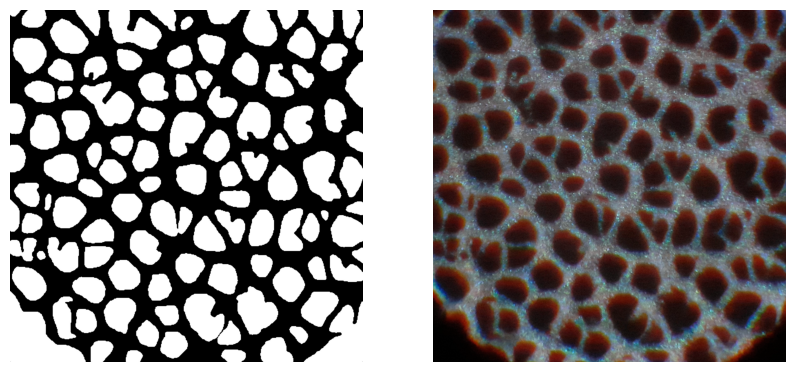

<Figure size 640x480 with 0 Axes>

In [5]:
## seleccionar una imagen aleatoria
idx = 0
mask_route = routes_dataset['route_mask'].to_numpy()[idx]
image_route = routes_dataset['route_image'].to_numpy()[idx]

## plot mascara y original
mask = cv2.imread(mask_route)
image = cv2.imread(image_route)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mask)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image)
plt.axis('off')
plt.show()
plt.tight_layout()

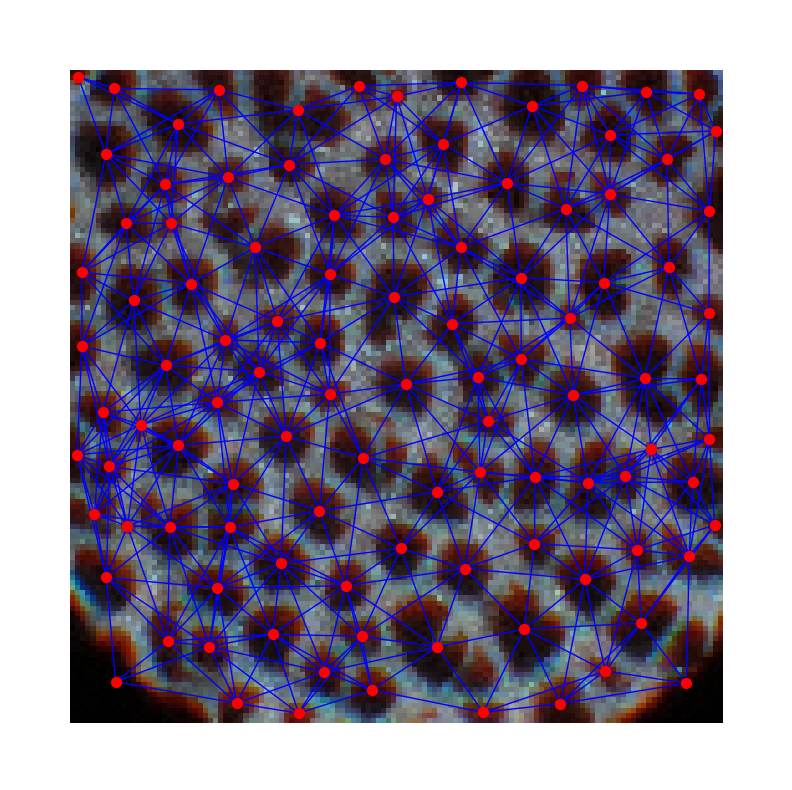

In [6]:
## graph for distances
## crear grafo
G = nx.Graph()

## añadir nodos definidos por su posición x,y
for i in range(len(pores_location)):
    ## node properties
    x = pores_location['cx'].to_numpy()[i]
    y = pores_location['cy'].to_numpy()[i]
    
    ## add node
    G.add_node(i,pos=(x,y))
    
## añadir aristas
for i in range(len(pores_location)):
    for j in range(i+1,len(pores_location)):
        ## distancia euclidiana
        x1 = pores_location['cx'].to_numpy()[i]
        y1 = pores_location['cy'].to_numpy()[i]
        x2 = pores_location['cx'].to_numpy()[j]
        y2 = pores_location['cy'].to_numpy()[j]
        dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        ## añadir arista si la distancia es menor a 10
        if dist < 128*0.2:
            G.add_edge(i,j,weight=dist)
            
## dibujar grafo sobre la imagen original 
plt.figure(figsize=(10,10))
## redimensionar imagen para que se ajuste al grafo 128x128
image = cv2.resize(image,(128,128))
plt.imshow(image)
plt.axis('off')
## dibujar nodos
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos,node_size=50,node_color='red',with_labels=False,edge_color='blue')

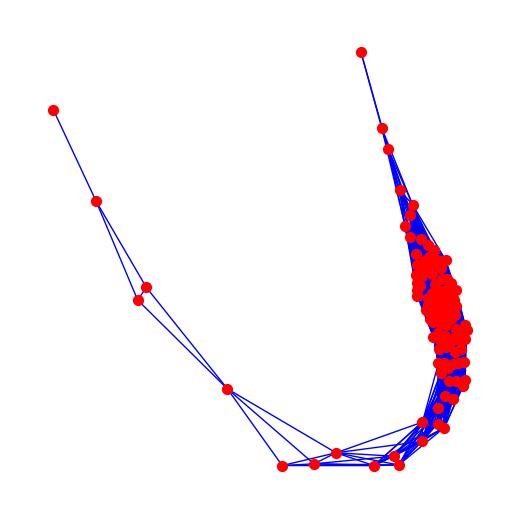

3


<Figure size 640x480 with 0 Axes>

In [7]:
## Graphgym
## visualizar grafo
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

mask_route = routes_dataset['route_mask'].to_numpy()[0]

data = image_to_grapph(mask_route)

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G)
plt.figure(figsize=(5,5))
nx.draw(G, pos, node_size=50, node_color='red', with_labels=False, edge_color='blue')
plt.show()
plt.tight_layout()    
print(data.num_features)

### Crear DataLoader

In [8]:
class MFsImagesDataset(Dataset):
    def __init__(self, routes_dataframe):
        self.routes_dataframe = routes_dataframe
        self.image_paths = []
        self.mask_paths = []
        self.labels = []
        self.electro_deposed_mass = []
        self.electro_active_area = []
        self.retained_mass = []
        self.graphs = []
        self.transform_mask = transforms.Compose([
            transforms.Grayscale(), # Ensure the image is grayscale
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.RandomRotation(180),       
            transforms.Resize((128, 128)),  # Resize to 128x128
            transforms.ToTensor(),
        ])
        self.transform_image = transforms.Compose([
            transforms.Resize((128, 128)),  # Resize to 128x128
            #data_augmentation,
            transforms.Grayscale(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(90),
            transforms.RandomRotation(180),            
            transforms.ToTensor(),
        ])       
        
        # Recursively gather all image paths in the folder and subfolders
        for idx in range(len(self.routes_dataframe)):
            mask_route = self.routes_dataframe['route_mask'].to_numpy()[idx]
            image_route = self.routes_dataframe['route_image'].to_numpy()[idx]
            clase = torch.tensor(self.routes_dataframe['label'].to_numpy()[idx])
            electro_deposed_mass = torch.tensor(self.routes_dataframe['mass_electrodeposited'].to_numpy()[idx])
            electro_active_area = torch.tensor(self.routes_dataframe['area_electroactive'].to_numpy()[idx])
            retained_mass = torch.tensor(self.routes_dataframe['retained_mass'].to_numpy()[idx])
            
            self.image_paths.append(image_route)
            self.mask_paths.append(mask_route)
            self.labels.append(clase)
            self.electro_deposed_mass.append(electro_deposed_mass)
            self.electro_active_area.append(electro_active_area)
            self.retained_mass.append(retained_mass)
                          
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        ## leer imagen, más y etiqueta
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image_label = self.labels[idx]
        image_electro_deposed_mass = self.electro_deposed_mass[idx]
        image_electro_active_area = self.electro_active_area[idx]
        image_retained_mass = self.retained_mass[idx]
        
        ## cargar imagen y máscara y aplicar transformaciones
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        image = self.transform_image(image)
        mask = self.transform_mask(mask)
        ## obtener propiedades de los poros de la máscara
        graph = image_to_grapph(mask_path,max_diff = 0.2)
        
                    
        return image, mask, graph, image_label, image_electro_deposed_mass, image_electro_active_area, image_retained_mass

def collate_fn(batch):
    import torch_geometric
    images, masks, graphs, labels, image_electro_deposed_mass, image_electro_active_area, image_retained_mass = zip(*batch)
    
    # Convert lists to tensors if necessary
    images = torch.stack(images)
    masks = torch.stack(masks)
    labels = torch.tensor(labels)
    image_electro_deposed_mass = torch.tensor(image_electro_deposed_mass)
    image_electro_active_area = torch.tensor(image_electro_active_area)
    image_retained_mass = torch.tensor(image_retained_mass)
    
    # Batch the graphs using torch_geometric's batch function
    graphs = torch_geometric.data.Batch.from_data_list(graphs)
    
    return images, masks, graphs, labels, image_electro_deposed_mass, image_electro_active_area, image_retained_mass
    
## split dataset into train and test 80-20
train_df, test_df = split_dataset(routes_dataset)

train_dataset = MFsImagesDataset(train_df)
test_dataset = MFsImagesDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

Clase MF1: train:  123 , test:  30
Clase MF2: train:  133 , test:  33
Clase MF3: train:  112 , test:  27


In [9]:
for image, mask, graph, label, edm, eaa, rm in train_loader:
    print('Image shape:', image.shape)
    print('Mask shape:', mask.shape)
    print('label')
    print('Graph information:')
    print('Number of nodes:', graph.num_nodes)
    print('Number of edges:', graph.num_edges)
    print('Number of features:', graph.num_features)
    print('Number of edge features:', graph.num_edge_features)
    print('Number of node features:', graph.num_node_features)
    break

Image shape: torch.Size([1, 1, 128, 128])
Mask shape: torch.Size([1, 1, 128, 128])
label
Graph information:
Number of nodes: 30
Number of edges: 179
Number of features: 3
Number of edge features: 0
Number of node features: 3


# Modelo

In [10]:
#https://github.com/pyg-team/pytorch_geometric

#https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95
#https://github.com/pyg-team/pytorch_geometric

import torch
from torch import Tensor
from torch_geometric.nn import GCNConv

## Graph convoluitonal network for classification
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.classifier = nn.Linear(out_channels, 3)
        

    def forward(self, x, edge_index):        
        x = self.conv1(x, edge_index).relu()
        #print(f'After conv1 x shape: {x.shape}')
        
        x = self.conv2(x, edge_index).relu()
        #print(f'After conv2 x shape: {x.shape}')# Initialize the model
        
        x = self.conv3(x, edge_index).relu()
        #print(f'After conv3 x shape: {x.shape}')
        
        x = torch.mean(x, dim=0)  # Example: mean pooling
        #print(f'After pooling x shape: {x.shape}')
        
        x = self.classifier(x)
        return x 
        
import torch.nn.functional as F
import time

model = GCN(in_channels=3, hidden_channels=64, out_channels=64, num_classes=3)

model.load_state_dict(torch.load('Models/model_gnn_2.pth'))


<All keys matched successfully>

## Metrics evaluation for classification

In [11]:
## evaluaton

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for image, mask, graph, label, edm, eaa, rm in test_loader:
        
        x = graph.x
        edge_index = graph.edge_index        
        
        pred = model(x, edge_index)
        # argmax
        pred = torch.argmax(pred, dim=-1)
        label = label.squeeze()
        
        ## create one hot encoding
        label = F.one_hot(label, num_classes=3)
        pred = F.one_hot(pred, num_classes=3)
        
        ## turn to int tensor
        label = label.type(torch.FloatTensor)
        pred = pred.type(torch.FloatTensor)   
        
        predictions.append(pred)
        true_labels.append(label)   
        
print('Predictions:',predictions)
print('True labels:',true_labels)     

Predictions: [tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([0., 1., 0.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([0., 0., 1.]), tensor([0., 0., 1.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.

In [12]:
## replace prediction tensor for numbers
predictions_array = np.argmax(predictions,axis=1)
true_labels_array = np.argmax(true_labels,axis=1)

#classification report
from sklearn.metrics import classification_report
target = ['MF1','MF2','MF3']
print(classification_report(true_labels_array,predictions_array,target_names=target))

              precision    recall  f1-score   support

         MF1       0.76      0.87      0.81        30
         MF2       0.83      0.76      0.79        33
         MF3       1.00      0.96      0.98        27

    accuracy                           0.86        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.86      0.86      0.86        90

